In [5]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 13 09:47:38 2023

@author: annik
"""
from matplotlib import pyplot as plt
import numpy as np
import collections
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.set_printoptions(edgeitems=2)
#torch.manual_seed(123)

print(device)


class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
# Trainingsdatensatz:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_augmented = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        T.RandomHorizontalFlip(),
        T.RandomCrop(32),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

# Validation data:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


# find all birds and planes:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]

cifar2_augmented = [(img, label_map[label])
          for img, label in cifar10_augmented
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

transform = transforms.Compose([T.Pad(4, padding_mode='reflect') ,T.RandomHorizontalFlip(),T.RandomCrop(32),transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))])
import itertools






class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )



    def forward(self, x):
        residual = x
        #out = F.relu(self.bn1(self.conv1(x)))
        #out = self.bn2(self.conv2(out))
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(residual)
        #out = F.relu(out)
        return out




class WRN(nn.Module):
    def __init__(self, depth, widen_factor, num_classes):
        super(WRN, self).__init__()
        assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
        self.n = (depth - 4) // 6
        self.k = widen_factor
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.layer1 = self._make_layer(16 * self.k, stride=1)
        self.layer2 = self._make_layer(32 * self.k, stride=2)
        self.layer3 = self._make_layer(64 * self.k, stride=2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * self.k, num_classes)



    def _make_layer(self, out_channels, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(self.n - 1):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)



    def forward(self, x):
        #out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out




# Create WRN-28-2-B(3,3) model
model = WRN(depth=28, widen_factor=2, num_classes=2)

if torch.cuda.is_available():
  model.cuda()

# Print the model architecture
print(model)

# Trainingsloop für Validierungs- und Trainingsdaten:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    trainingsloss = np.zeros(n_epochs)
    validierungsloss = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = transform(imgs)
            imgs, labels = imgs.to(device=device), labels.to(device=device)
            outputs = model(imgs)
            losses_train = loss_fn(outputs, labels)
            optimizer.zero_grad()
            losses_train.backward()
            optimizer.step()
            loss_train += losses_train.item()

        loss_val = 0.0
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device=device), labels.to(device=device)
            outputs = model(imgs)
            losses_val = loss_fn(outputs, labels)
            optimizer.zero_grad()
            # losses_val.backward()
            optimizer.step()
            loss_val += losses_val.item()

        if epoch == 1 or epoch % 10 == 0:
          print(f"Epoch {epoch}, Training loss {loss_train / len(train_loader):.4f},"
          f" Validation loss {loss_val / len(val_loader):.4f}")

        validierungsloss[epoch-1] = loss_val / len(val_loader) # Valideriungsverlust
        trainingsloss[epoch-1] = loss_train / len(train_loader) # Trainingsverlust

    return trainingsloss, validierungsloss

# Training
train_loader = torch.utils.data.DataLoader(cifar2_augmented, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                           shuffle=False)



optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

trainingsloss, validierungsloss = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)


cuda
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
WRN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (shortcut): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=

In [6]:


import collections
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):

    accdict = {}

    for name, loader in [("train", train_loader), ("val", val_loader)]:

        correct = 0

        total = 0




        with torch.no_grad():

            for imgs, labels in loader:

                imgs = imgs.to(device=device)

                labels = labels.to(device=device)

                outputs = model(imgs)

                _, predicted = torch.max(outputs, dim=1) # <1>

                total += labels.shape[0]

                correct += int((predicted == labels).sum())




        print("Accuracy {}: {:.2f}".format(name , correct / total))

        accdict[name] = correct / total

    return accdict


    all_acc_dict = collections.OrderedDict()




all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

print(sum(p.numel() for p in model.parameters()))

Accuracy train: 0.98
Accuracy val: 0.94
1466802


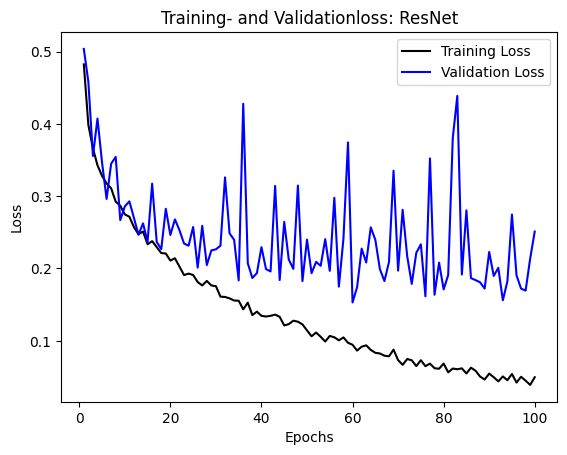

In [7]:
epochs_train = range(1, len(trainingsloss) + 1)
epochs_val = range(1, len(validierungsloss) + 1)
fig = plt.figure(dpi=100)
plt.plot(epochs_train, trainingsloss, 'k', label='Training Loss')
plt.plot(epochs_val, validierungsloss, 'b', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training- and Validationloss: ResNet')
plt.legend(loc="best")
plt.show()

Im Gegensatz zu der Accuracy im Buch ist die von unserem Resnet bei der Validierung deutlich höher. Die Trainingsaccuracy ist ungefähr gleich. Bei unserem Netz ist im Verlauf des Validierungsloss aber auch zu sehen, dass es zu einem Overfitting kommt. Wahrscheinlich kommt es bei dem ResNet im Buch nicht zu einem Übertraining was dann für die geringere Validierungsaccuracy spricht.